In [1]:
working_directory = '/kaggle/working'
dataset_directory = '/kaggle/input/kla-dataset/Denoising_Dataset_train_val'
patch_directory = '/kaggle/input/training-patch-dataset'
checkpoint_directory = '/kaggle/input/model-checkpoints/pytorch/default/1/Model Checkpoints'

In [2]:
import os
!git clone https://github.com/bhatheja/DnCNN_Implementation
os.chdir(f'{working_directory}/DnCNN_Implementation')

Cloning into 'DnCNN_Implementation'...
remote: Enumerating objects: 354, done.
remote: Counting objects: 100% (199/199), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 354 (delta 109), reused 159 (delta 89), pack-reused 155 (from 1)
Receiving objects: 100% (354/354), 8.32 MiB | 37.85 MiB/s, done.
Resolving deltas: 100% (189/189), done.


In [3]:
import util
import model
from utils import *
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loading the files for training

In [5]:
train_data = util.data_loading(directory = f"{dataset_directory}", dataset_type = 'Train')

Train Data: 100%|██████████| 932/932 [01:36<00:00,  9.66it/s]


### Creating patches (don't run it every time as it is the most lengthy process)
### Make patches once and save them

In [12]:
## if patch_size is 128x128 then every image will be divided into 64 patches

# util.patch_saving(train_data, patch_size_info = 128, data_type='train', folder_location = f'{working_directory}/patch_dataset')

Saving train images of patch size of 128


Type:1: 100%|██████████| 932/932 [04:01<00:00,  3.85it/s]

Images Saved to /kaggle/working/patch_dataset/128x128_patches/train


In [ ]:
# Zipping the patches for downloading

# !zip -r training_patches_128x128.zip /kaggle/working/patch_dataset

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Training the Model

In [9]:
num_epochs = 30
learning_rate = 0.001
train_patches = util.patches_load(directory = f'{patch_directory}', total_images = len(train_data))

100%|██████████| 932/932 [10:50<00:00,  1.43it/s]


In [ ]:
my_model = model.DnCNN(3).to(device)
criterion = nn.MSELoss()

for epoch in range(0, num_epochs):
    if epoch!=0:
        if epoch%5==0:
            learning_rate/=10
            
    optimizer = torch.optim.Adam(my_model.parameters(), lr=learning_rate)
    training_data = DataLoader(train_patches, batch_size = 64, shuffle = True)
    for i, (clean_image, noisy_image) in tqdm(enumerate(training_data), total=len(training_data), desc=f'{epoch+1}/{num_epochs+5}'):
        clean_image, noisy_image = clean_image.permute(0,3,1,2).float().to(device), noisy_image.permute(0,3,1,2).float().to(device)

        # Forward pass
        noisy_image = torch.nn.functional.pad(noisy_image, (1, 1, 1, 1, 0, 0, 0, 0), value=0)
        outputs = my_model(noisy_image)
        outputs = outputs[:, :, 1:-1, 1:-1]
        loss = criterion(outputs, clean_image)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    torch.save(my_model.state_dict(), f'/kaggle/working/ite_{epoch+1}.pth')
    
print("Training complete!")

## Testing the model performance for validation data

In [4]:
# Loading the validation data for testing

val_data = util.data_loading(directory = f"{dataset_directory}", dataset_type = 'Val')
dataloader = DataLoader(val_data, batch_size = 1, shuffle = False)

Val Data: 100%|██████████| 88/88 [00:09<00:00,  9.42it/s]


In [6]:
# Getting psnr value for each of the image in the validation data

folder_path = '/kaggle/input/model-checkpoints/pytorch/default/1/Model Checkpoints'
files = os.listdir(folder_path)
file_count = sum(1 for f in files if os.path.isfile(os.path.join(folder_path, f)))

psnr_arrays = []; ssim_arrays = []
# Start iteration from 1, 0 is for original degraded images
for ite in tqdm(range(1, file_count+1), total = file_count):
    my_model = model.DnCNN(channels=3).to(device)
    my_model.load_state_dict(torch.load(f"/kaggle/input/model-checkpoints/pytorch/default/1/Model Checkpoints/ite_{ite}.pth", map_location=torch.device(device), weights_only=False))
    my_model.to(device)
    my_model.eval()
    psnr_vals = util.psnr_values(dataloader, my_model, device, ite)
    ssim_vals = util.ssim_values(dataloader, my_model, device, ite)
    psnr_arrays.append(psnr_vals)
    ssim_arrays.append(ssim_vals)

100%|██████████| 34/34 [32:12<00:00, 56.84s/it]


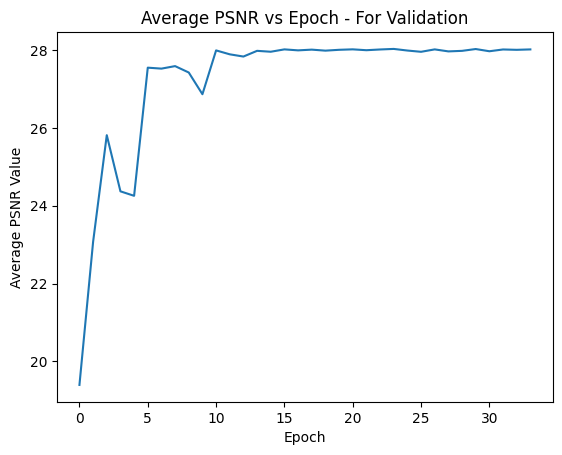

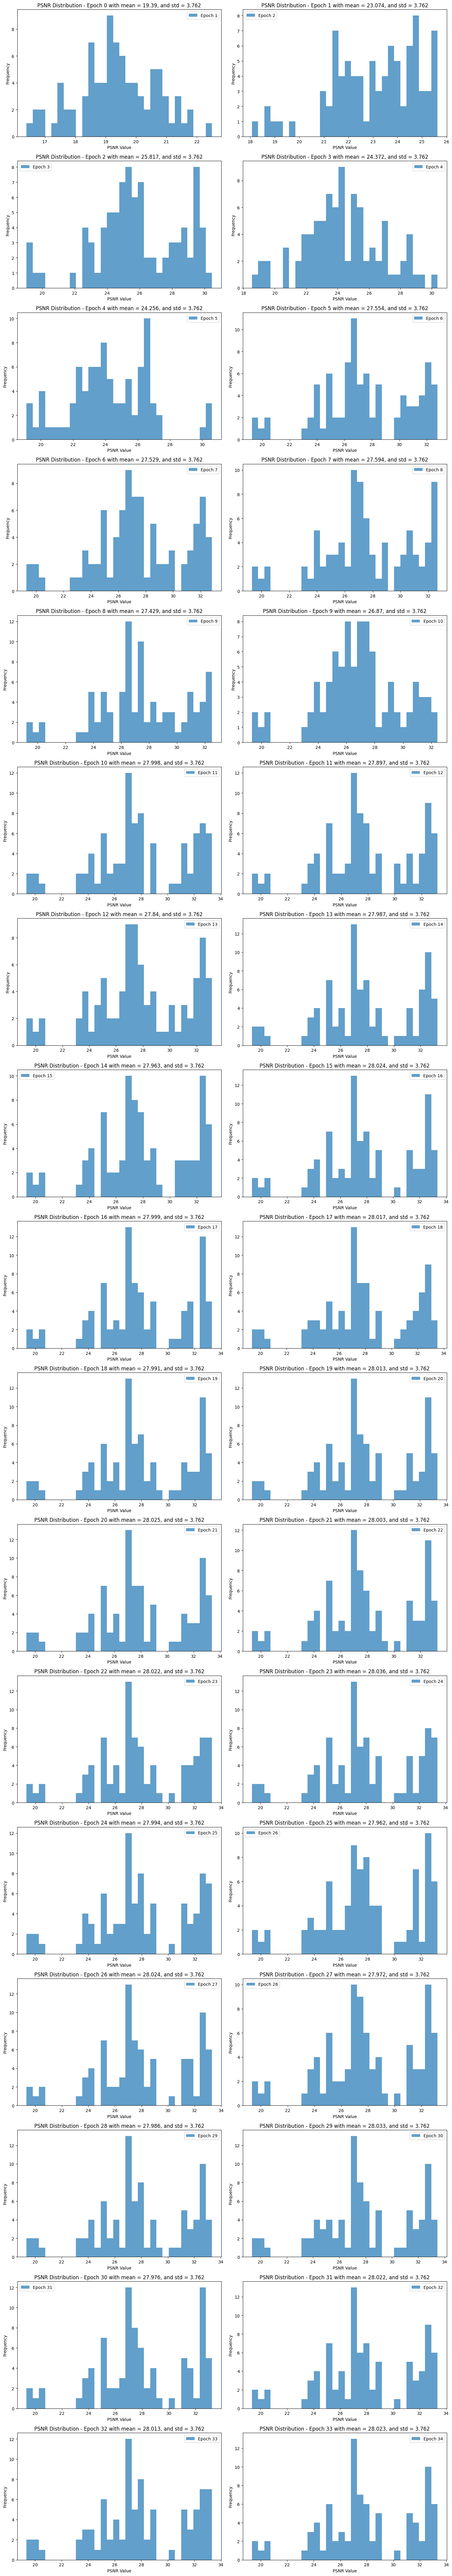

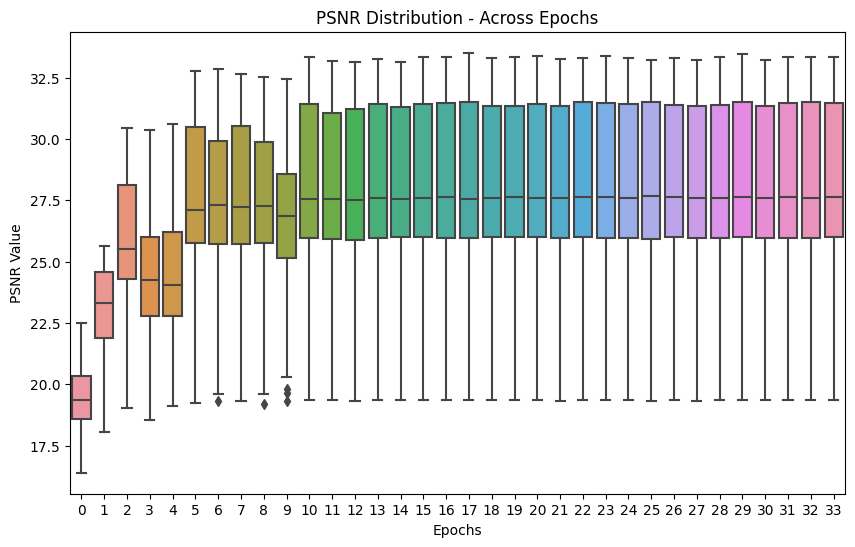

In [7]:
# Performance graphs (PSNR)

psnr_arrays = np.array(psnr_arrays)

psnr_vs_epoch = []
for i in range(len(psnr_arrays)):
    psnr_vs_epoch.append(psnr_arrays[i].mean())
plt.title('Average PSNR vs Epoch - For Validation')
plt.plot(psnr_vs_epoch); plt.xlabel('Epoch'); plt.ylabel('Average PSNR Value')
plt.show()

num_epochs = len(psnr_arrays)

ncols = 2
nrows = (num_epochs + ncols - 1) // ncols

plt.figure(figsize=(15, 5 * nrows))

for i in range(num_epochs):
    plt.subplot(nrows, ncols, i + 1)
    plt.hist(psnr_arrays[i], bins=30, alpha=0.7, label=f'Epoch {i+1}')
    plt.title(f'PSNR Distribution - Epoch {i} with mean = {round(psnr_arrays[i].mean(),3)}, and std = {round(psnr_arrays.std(),3)}')
    plt.xlabel('PSNR Value')
    plt.ylabel('Frequency')
    plt.legend()
plt.tight_layout()
plt.show()

data = [psnr_arrays[i] for i in range(len(psnr_arrays))]

plt.figure(figsize=(10, 6))
sns.boxplot(data=data)
plt.title('PSNR Distribution - Across Epochs')
plt.xlabel('Epochs')
plt.ylabel('PSNR Value')
plt.xticks(ticks=range(len(psnr_arrays)), labels=[f'{i}' for i in range(len(psnr_arrays))])
plt.show()

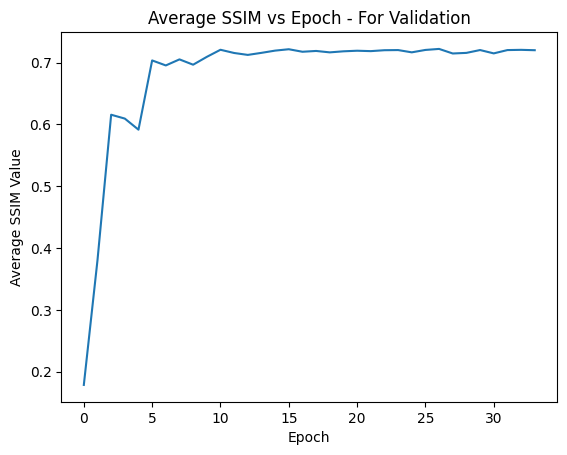

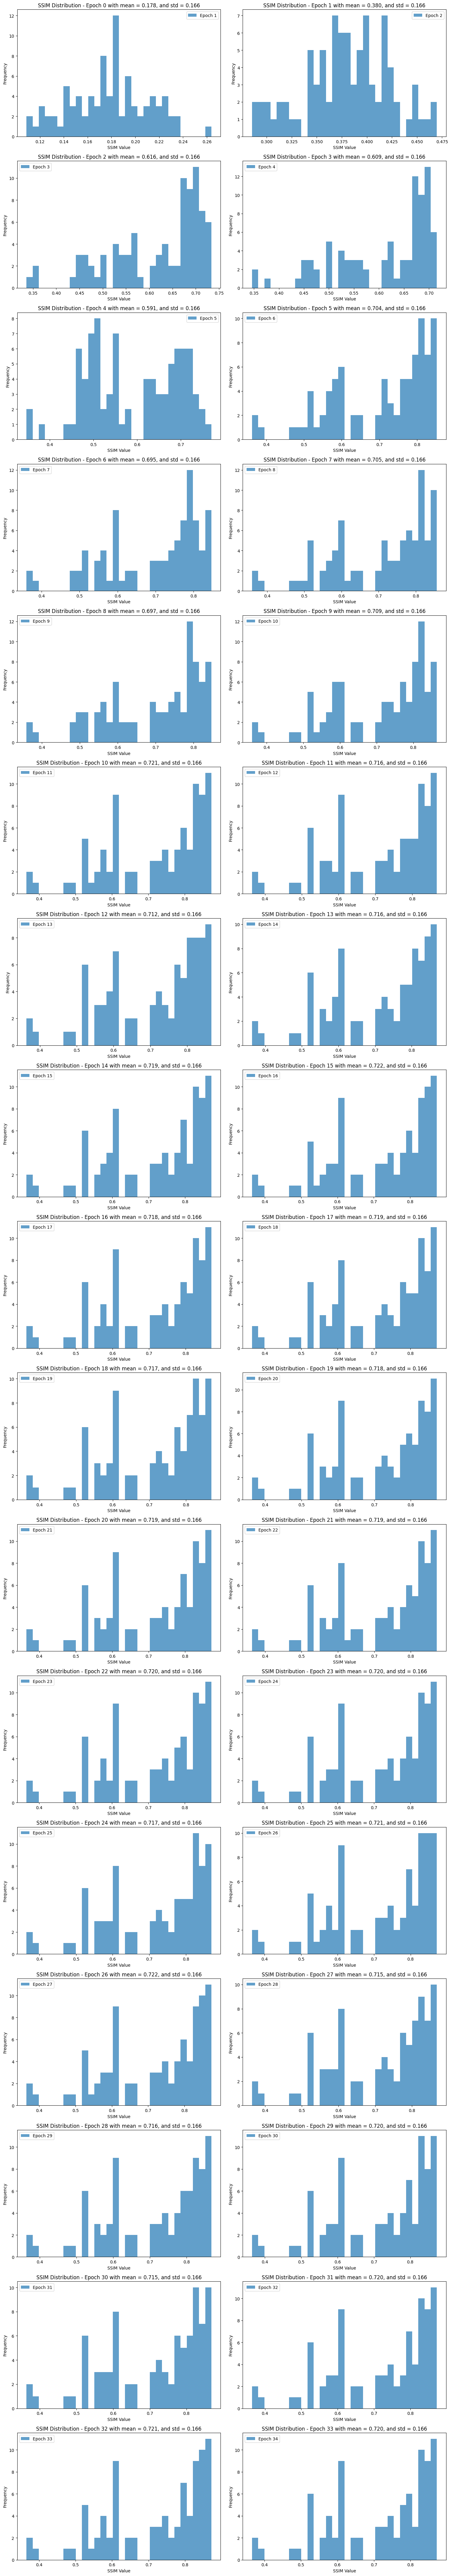

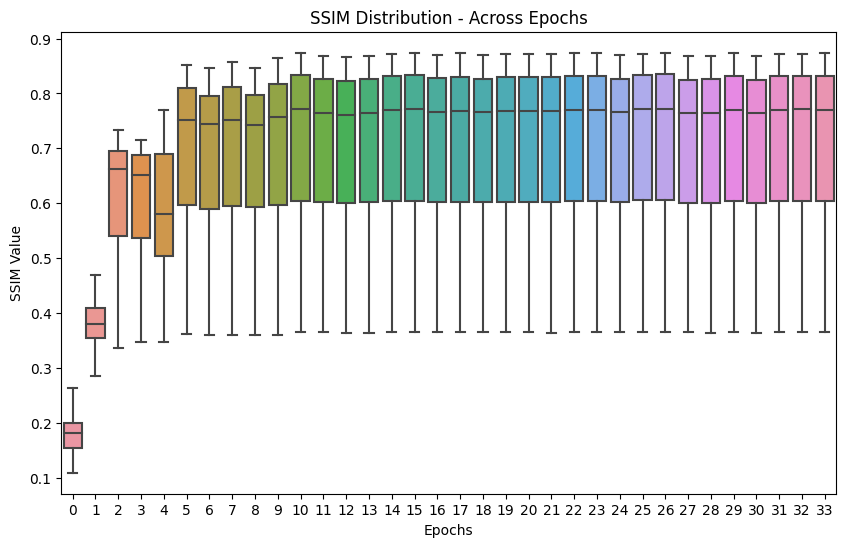

In [13]:
# Performance graphs (SSIM)

ssim_arrays = np.array(ssim_arrays)

ssim_vs_epoch = []
for i in range(len(ssim_arrays)):
    ssim_vs_epoch.append(ssim_arrays[i].mean())
plt.title('Average SSIM vs Epoch - For Validation')
plt.plot(ssim_vs_epoch); plt.xlabel('Epoch'); plt.ylabel('Average SSIM Value')
plt.show()

num_epochs = len(ssim_arrays)

ncols = 2
nrows = (num_epochs + ncols - 1) // ncols

plt.figure(figsize=(15, 5 * nrows))

for i in range(num_epochs):
    plt.subplot(nrows, ncols, i + 1)
    plt.hist(ssim_arrays[i], bins=30, alpha=0.7, label=f'Epoch {i+1}')
    plt.title(f'SSIM Distribution - Epoch {i} with mean = {ssim_arrays[i].mean():.3f}, and std = {ssim_arrays.std():.3f}')
    plt.xlabel('SSIM Value')
    plt.ylabel('Frequency')
    plt.legend()
plt.tight_layout()
plt.show()

data = [ssim_arrays[i] for i in range(len(ssim_arrays))]

plt.figure(figsize=(10, 6))
sns.boxplot(data=data)
plt.title('SSIM Distribution - Across Epochs')
plt.xlabel('Epochs')
plt.ylabel('SSIM Value')
plt.xticks(ticks=range(len(ssim_arrays)), labels=[f'{i}' for i in range(len(ssim_arrays))])
plt.show()

In [5]:
# Image Save

my_model = model.DnCNN(channels=3).to(device)
my_model.load_state_dict(torch.load(f"/kaggle/working/DnCNN_Implementation/model checkpoints/ite_34.pth", map_location=torch.device(device), weights_only=False))
my_model.to(device)
my_model.eval()

util.image_save(dataloader, my_model, device, directory = f'{working_directory}')

88it [01:57,  1.33s/it]


In [6]:
# !zip -r validation_output.zip /kaggle/working/validation_output

In [7]:
ssim, psnr, psnr_active = util.defect_ssim_psnr(f'{working_directory}')

100%|██████████| 88/88 [00:37<00:00,  2.37it/s]


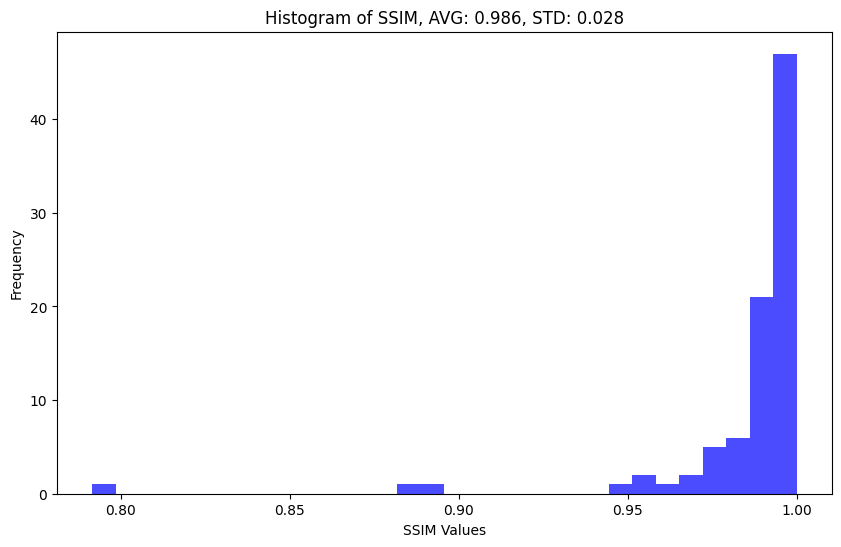

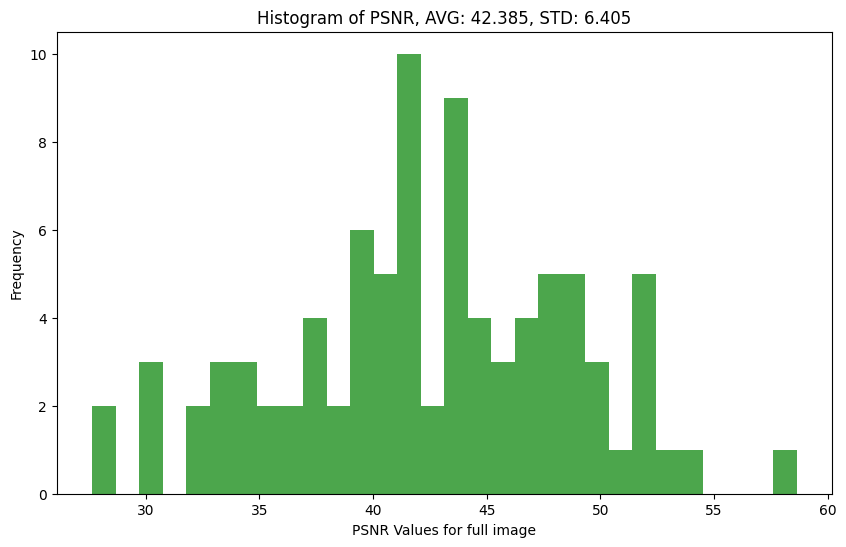

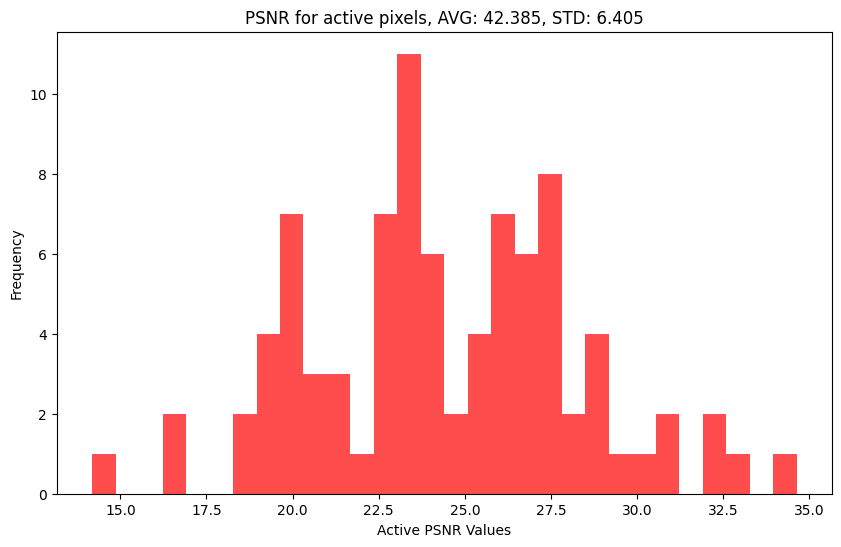

In [12]:
ssim = np.array(ssim)
psnr = np.array(psnr)
psnr_active = np.array(psnr_active)

plt.figure(figsize=(10, 6))
plt.hist(ssim, bins=30, alpha=0.7, color='blue')
plt.title(f'Histogram of SSIM, AVG: {ssim.mean():.3f}, STD: {ssim.std():.3f}')
plt.xlabel('SSIM Values')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(psnr, bins=30, alpha=0.7, color='green')
plt.title(f'Histogram of PSNR, AVG: {psnr.mean():.3f}, STD: {psnr.std():.3f}')
plt.xlabel('PSNR Values for full image')
plt.ylabel('Frequency')
plt.show()

# Plot histogram for active PSNR
plt.figure(figsize=(10, 6))
plt.hist(psnr_active, bins=30, alpha=0.7, color='red')
plt.title(f'PSNR for active pixels, AVG: {psnr.mean():.3f}, STD: {psnr.std():.3f}')
plt.xlabel('Active PSNR Values')
plt.ylabel('Frequency')
plt.show()

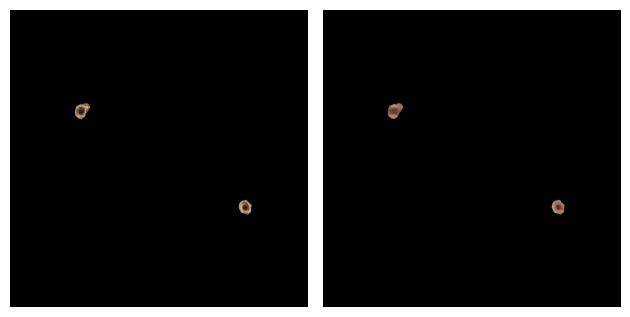

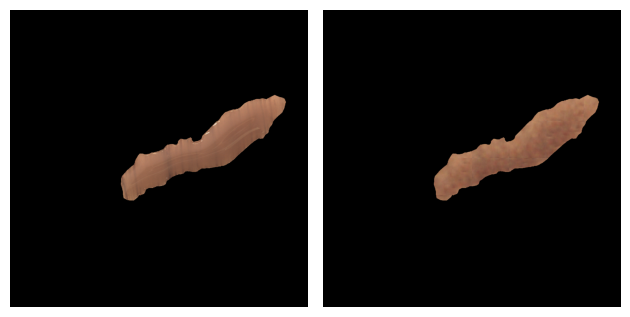

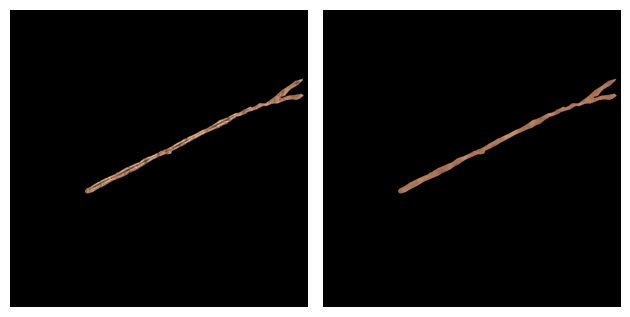

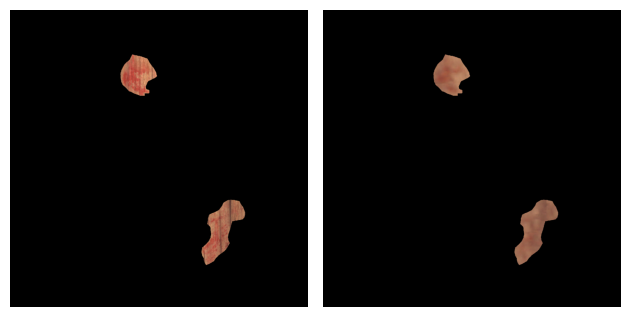

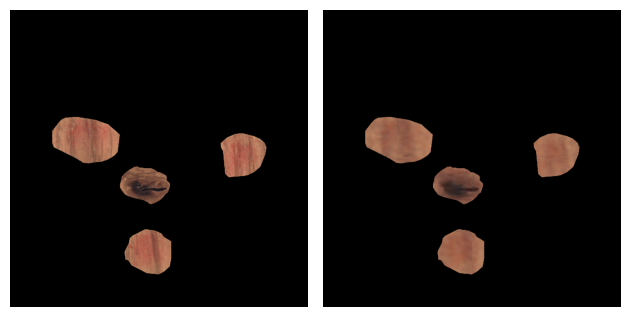

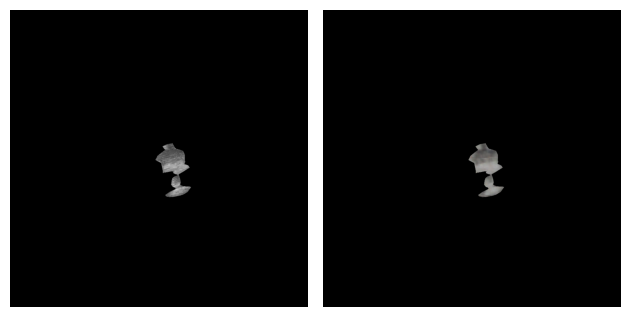

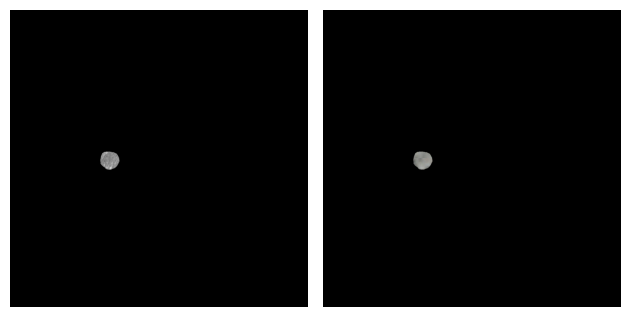

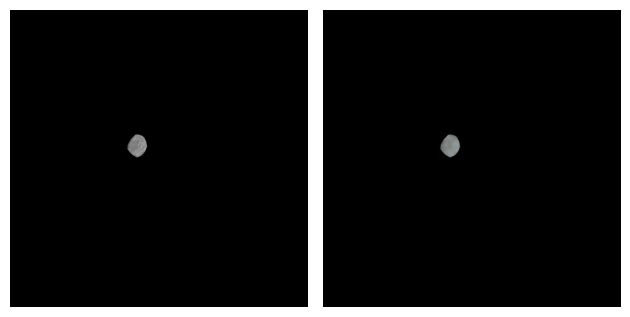

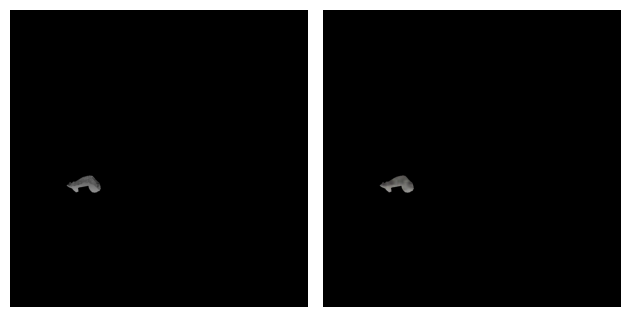

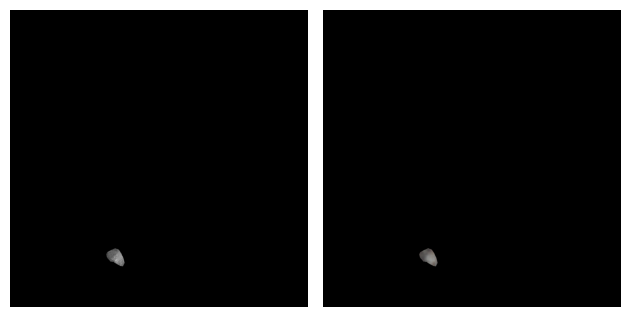

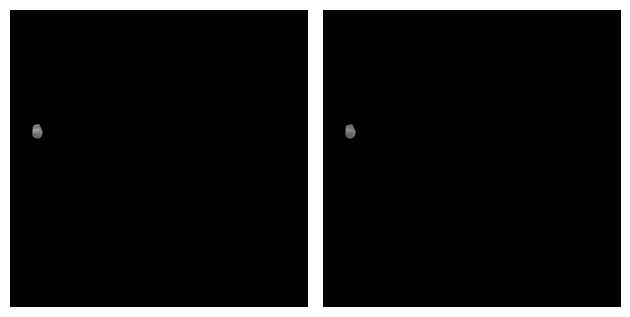

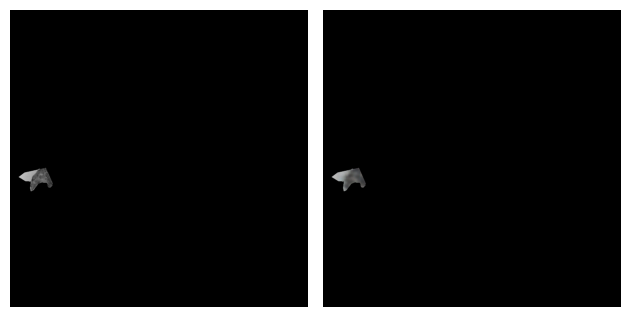

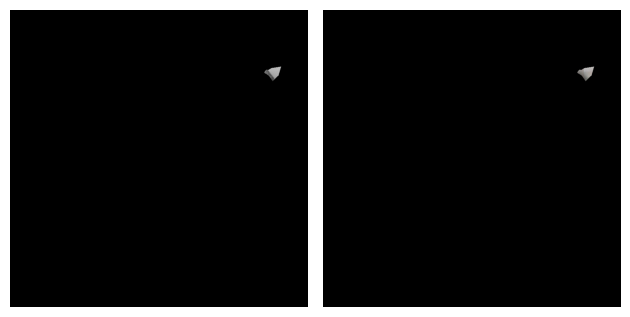

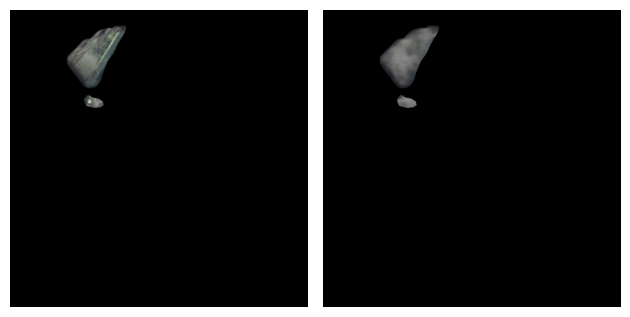

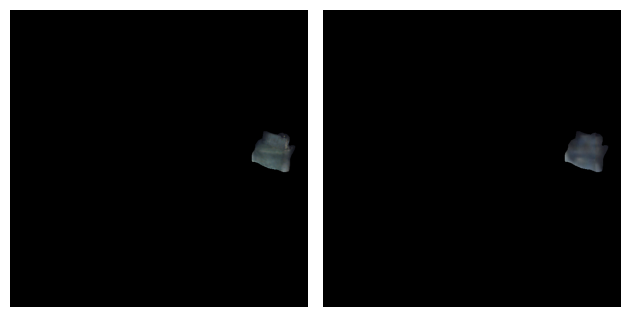

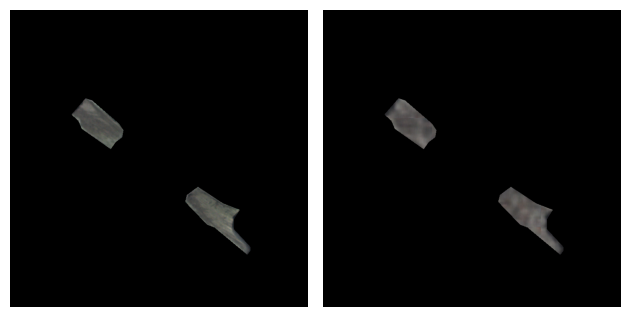

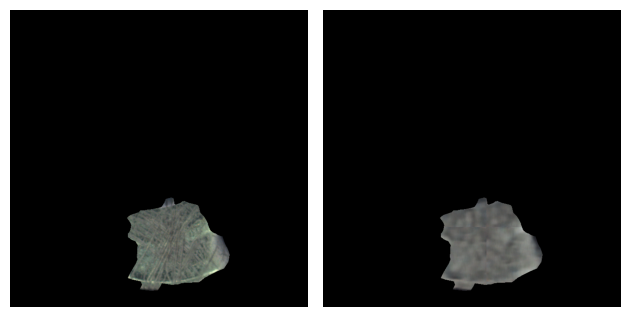

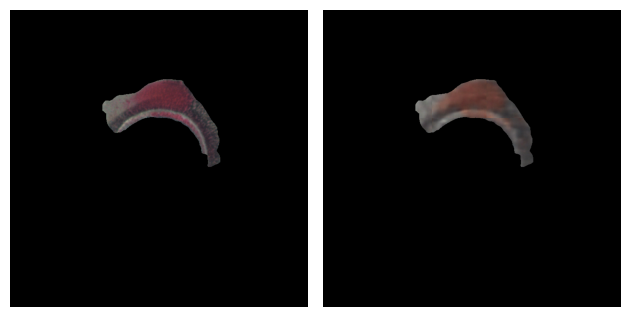

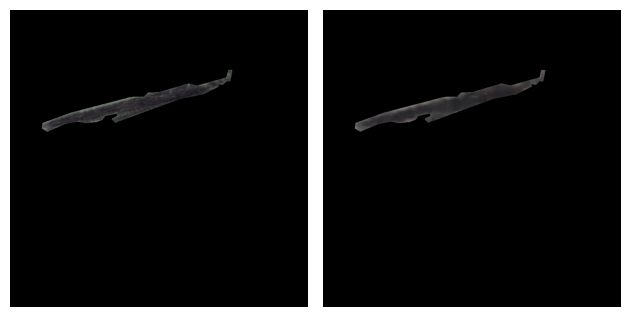

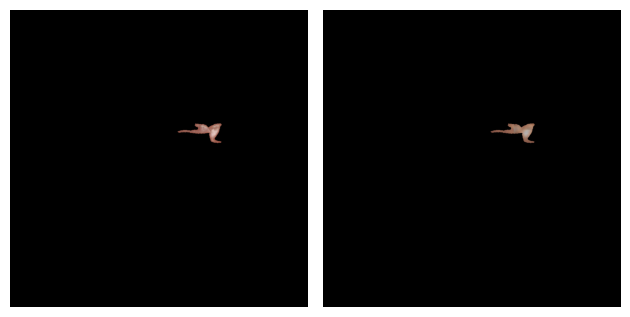

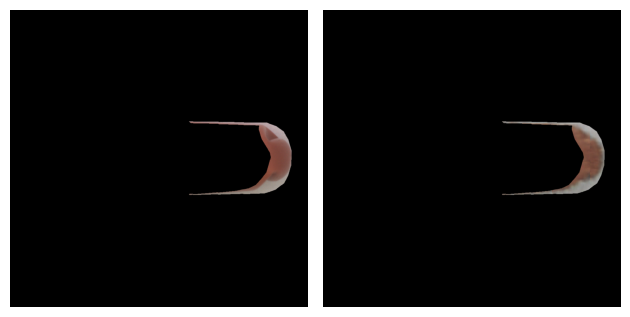

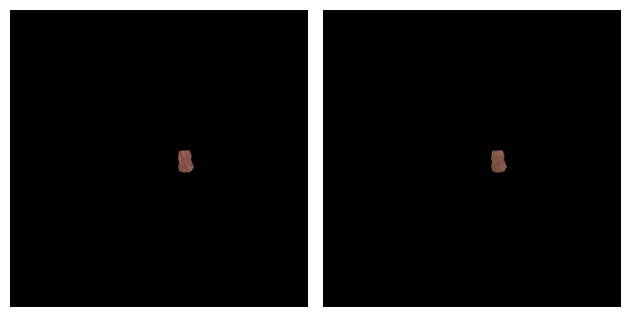

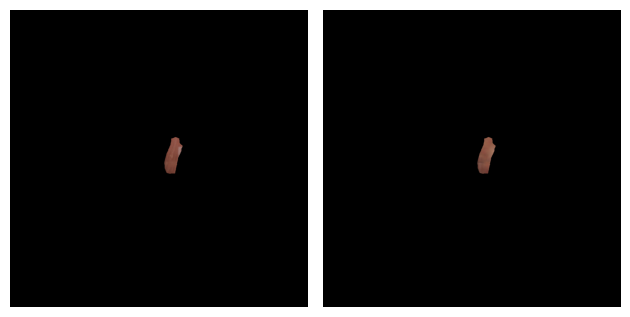

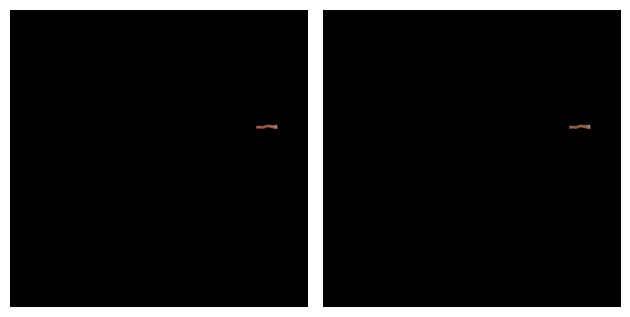

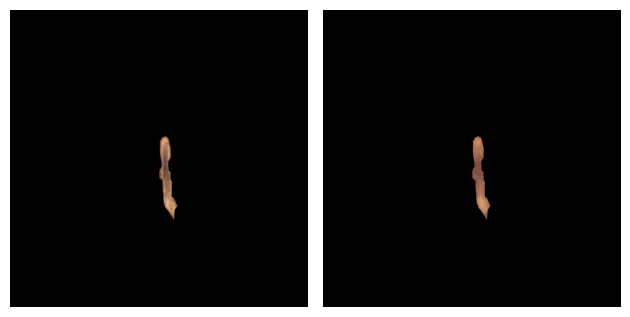

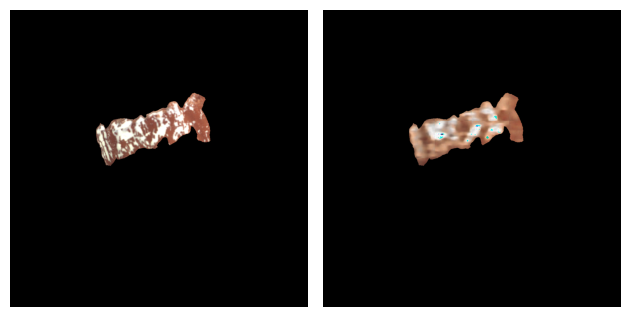

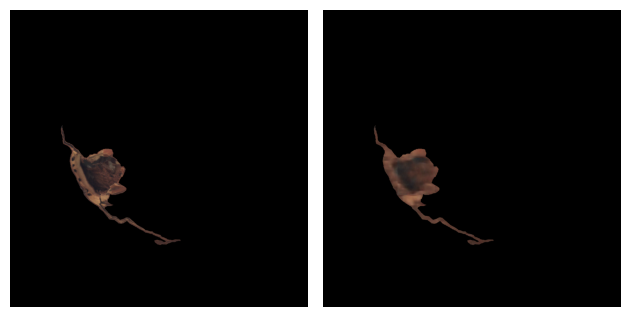

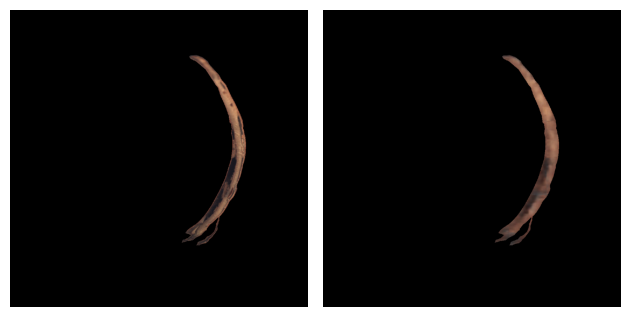

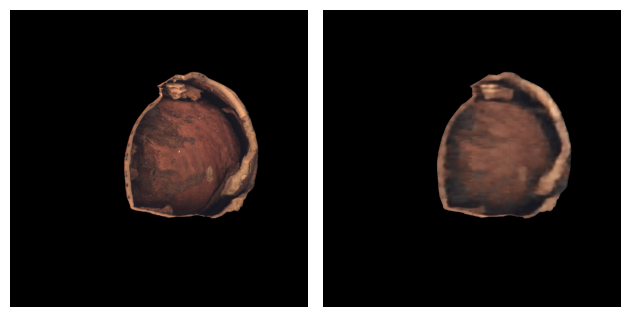

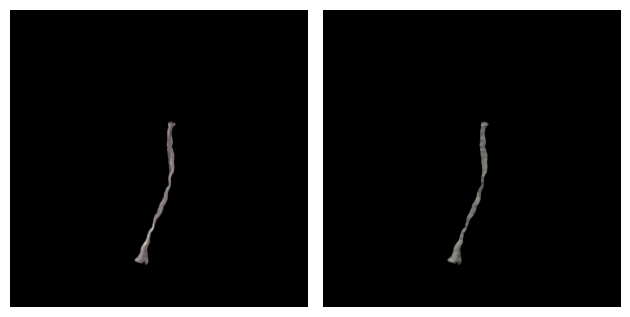

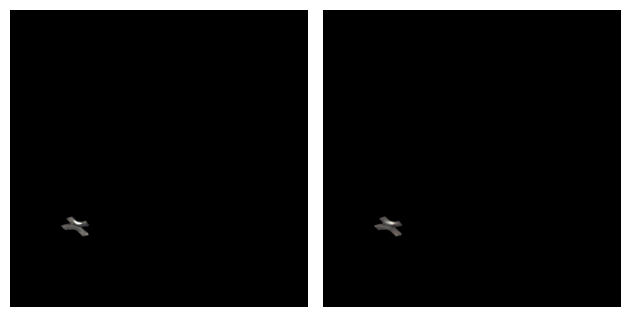

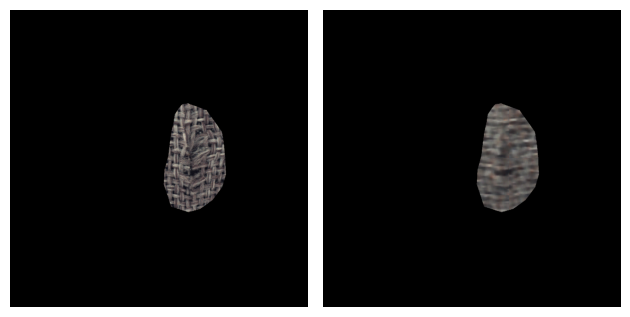

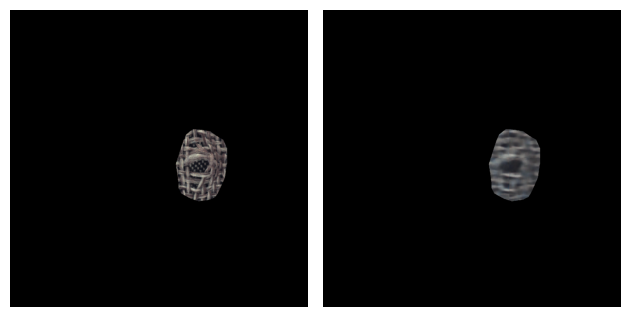

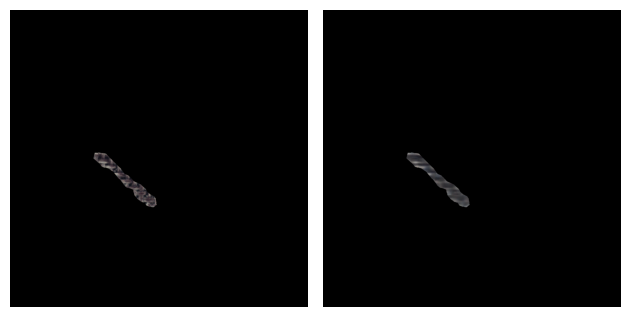

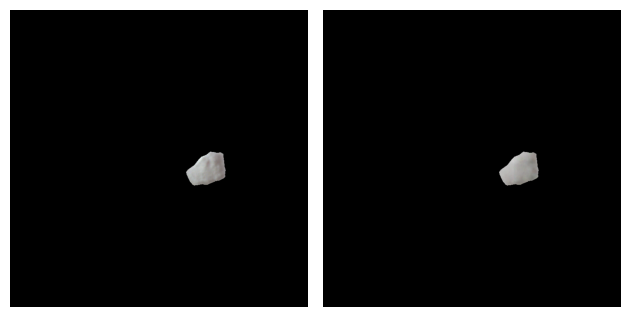

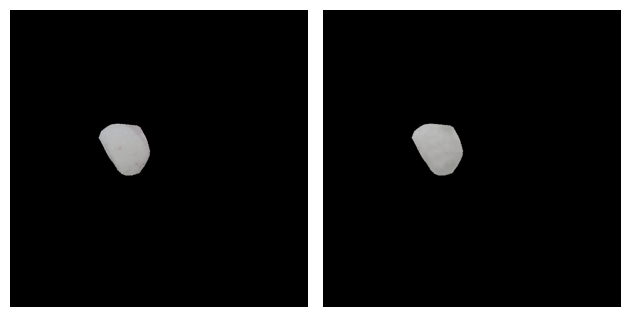

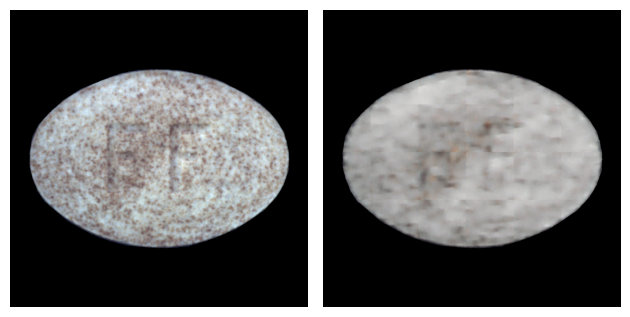

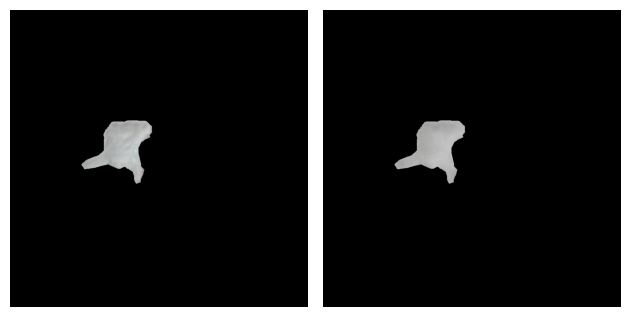

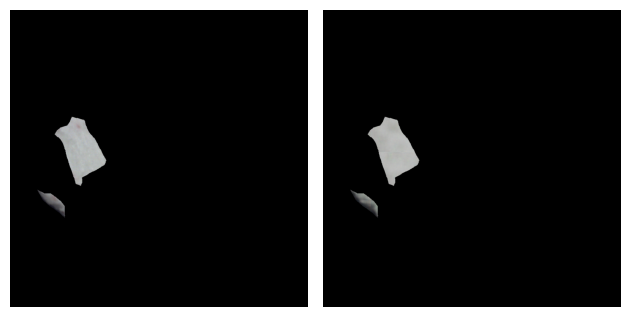

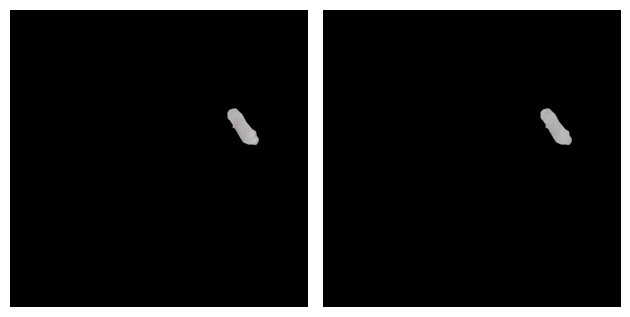

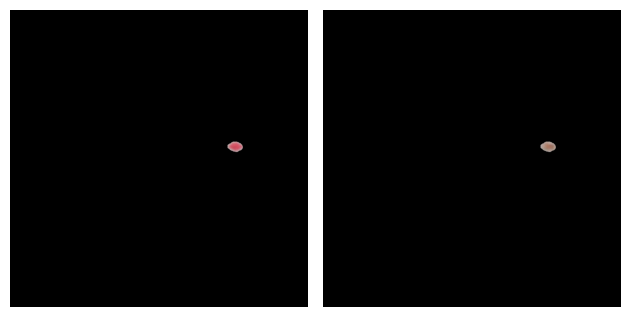

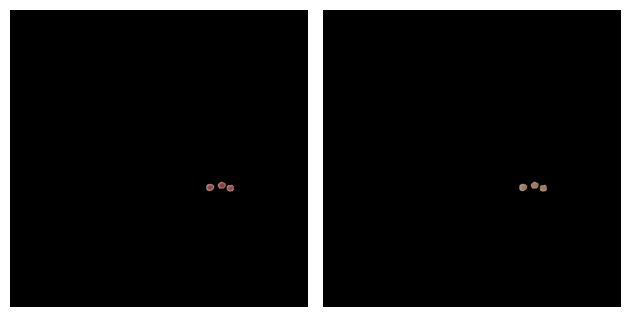

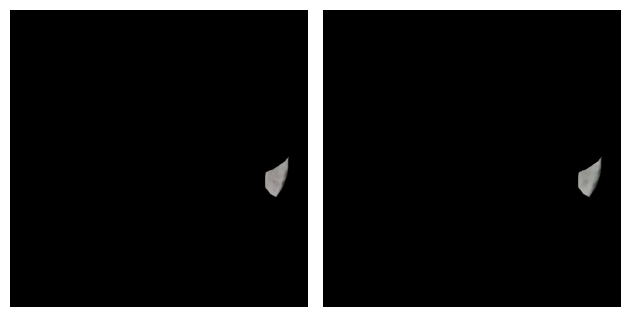

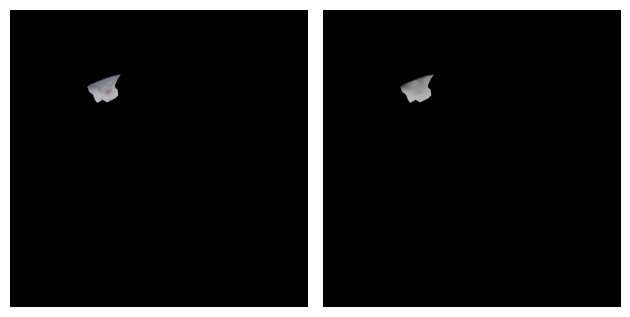

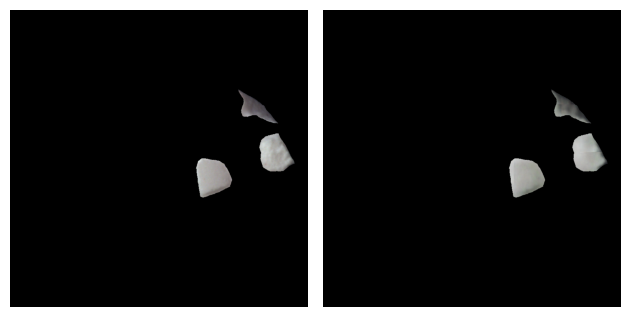

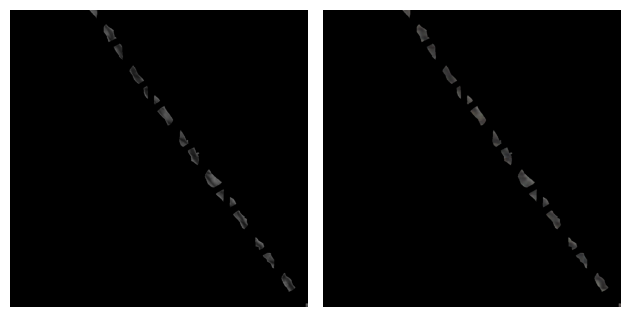

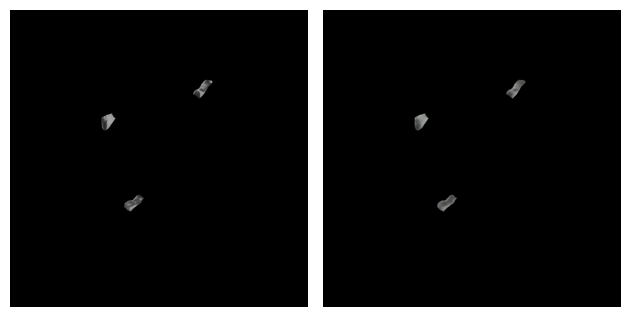

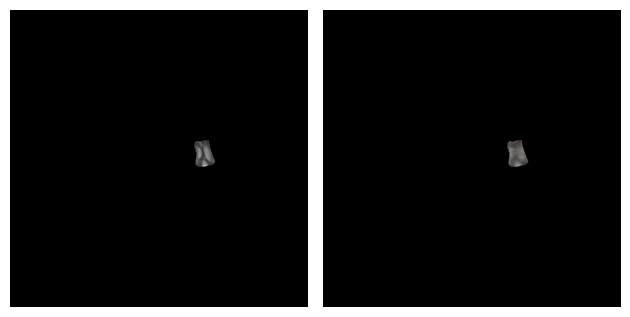

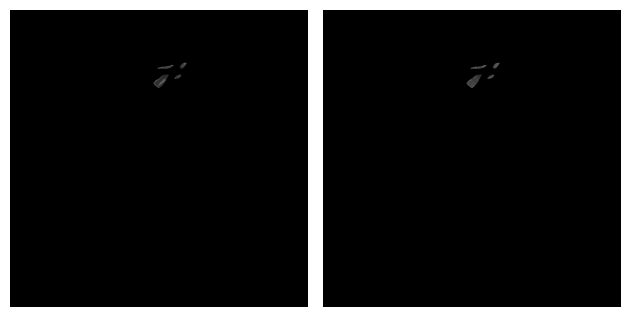

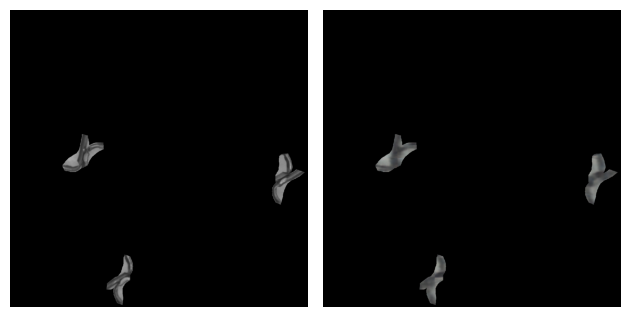

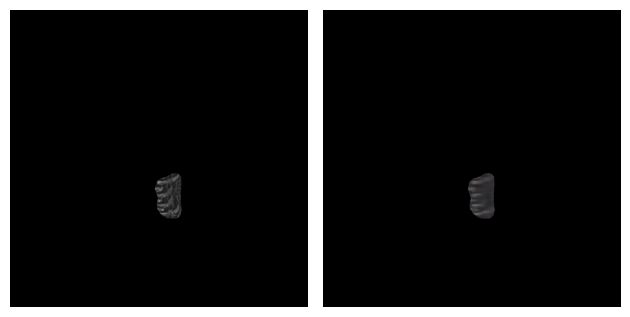

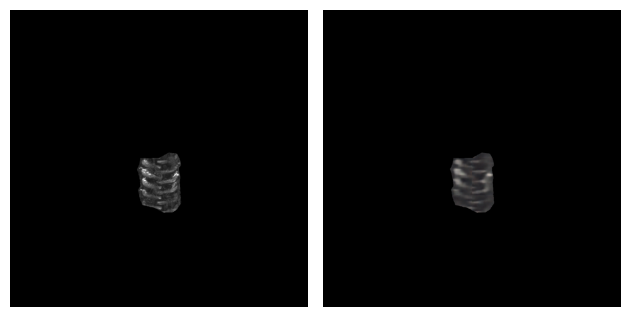

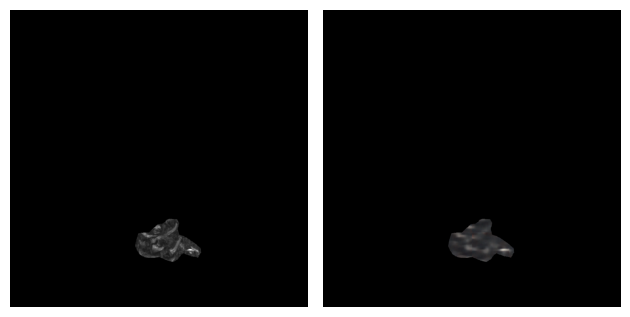

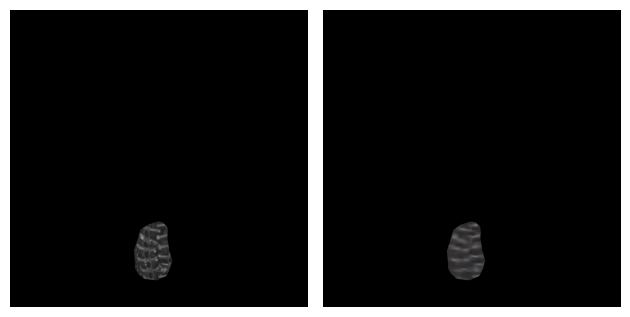

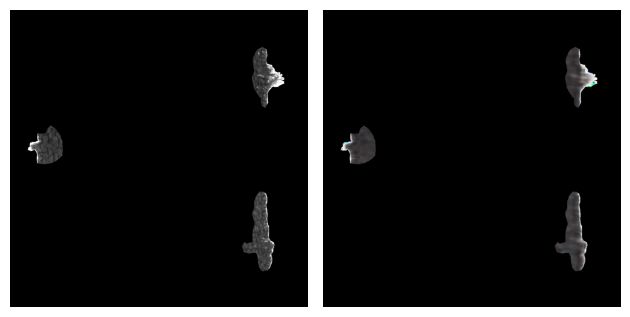

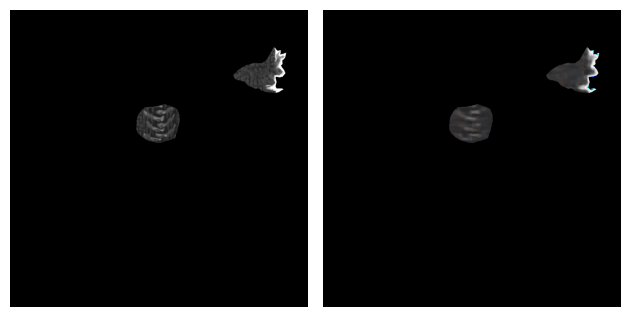

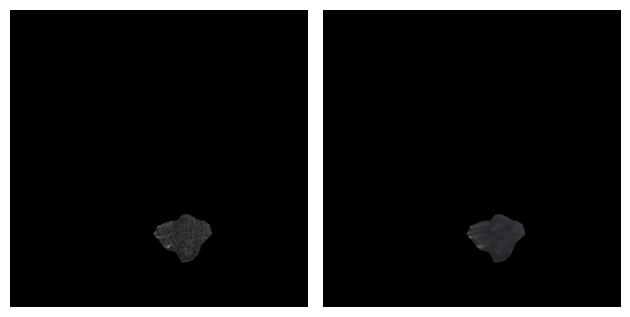

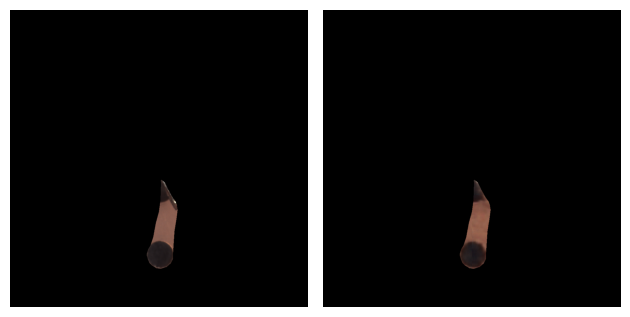

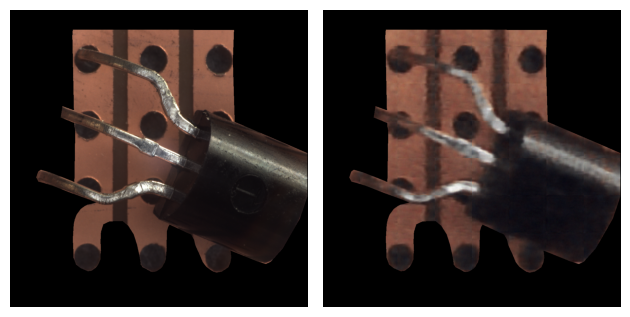

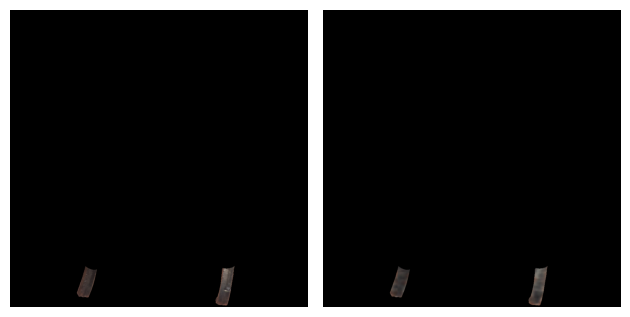

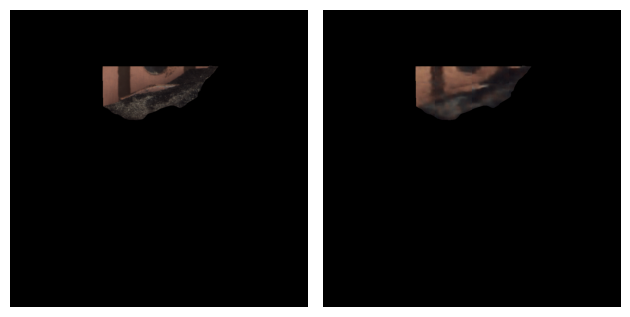

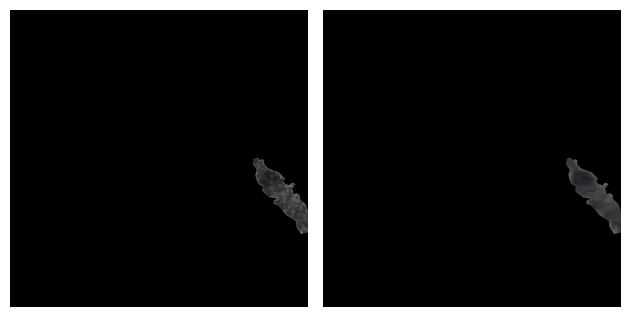

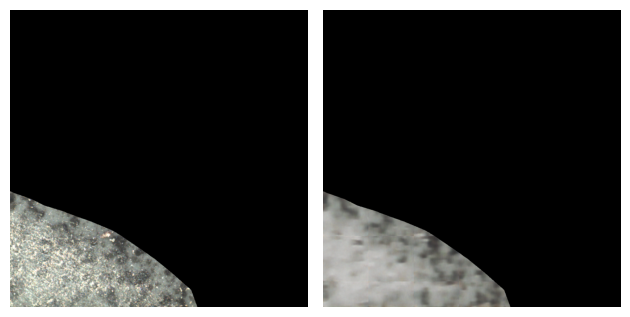

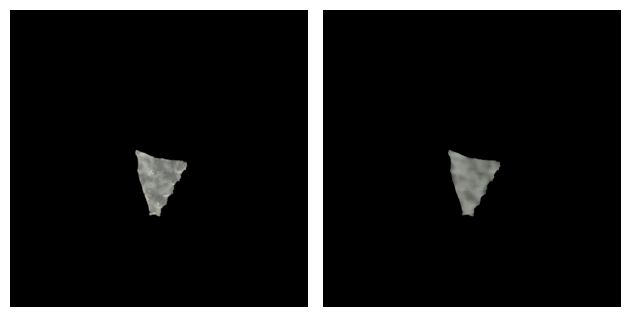

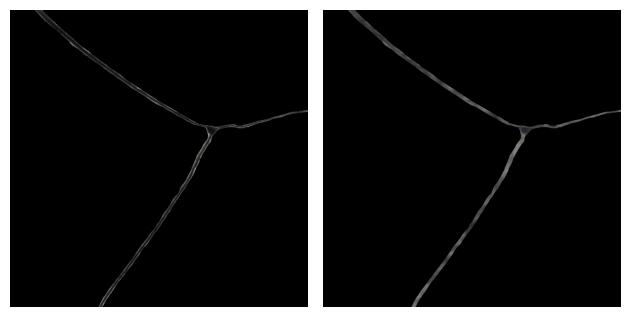

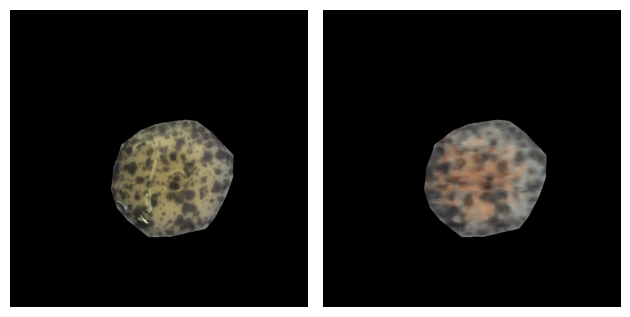

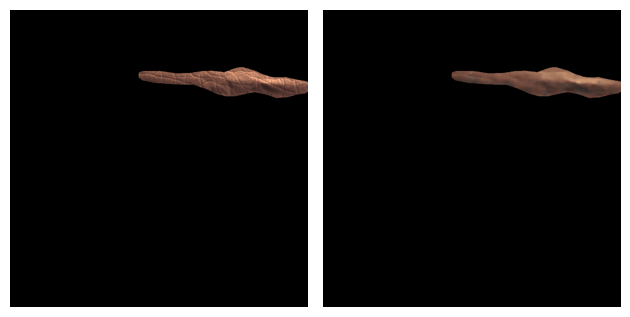

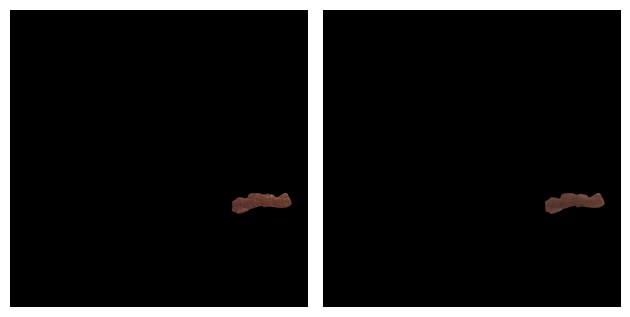

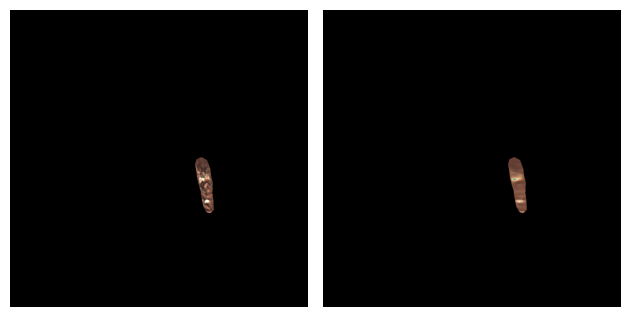

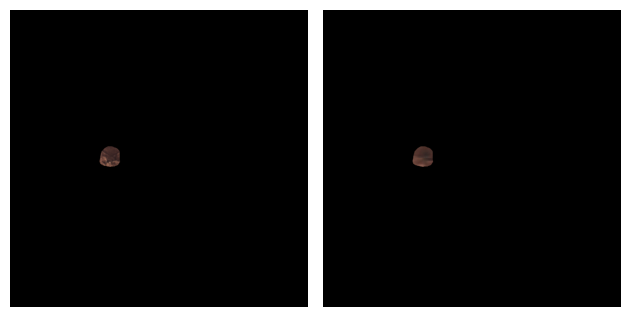

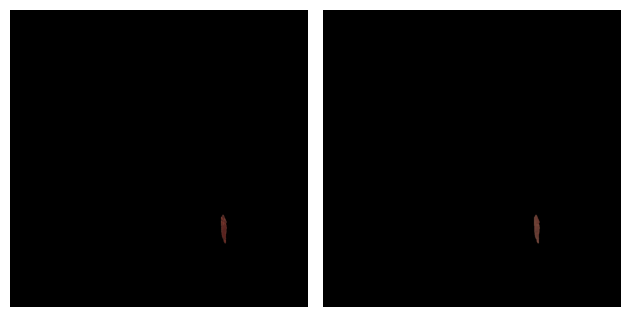

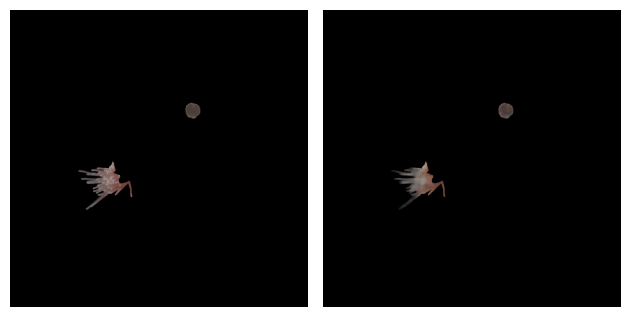

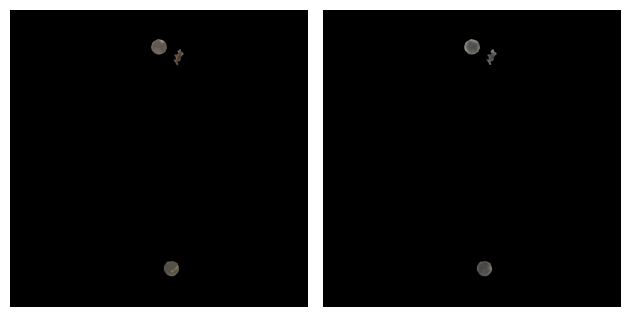

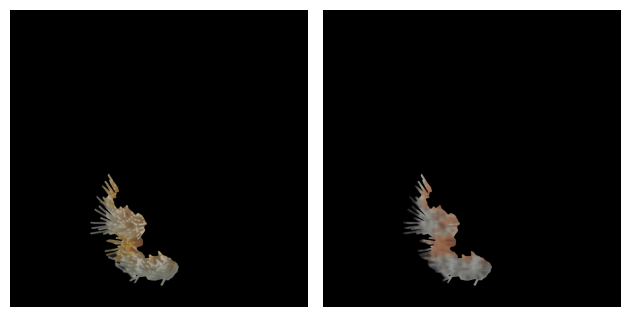

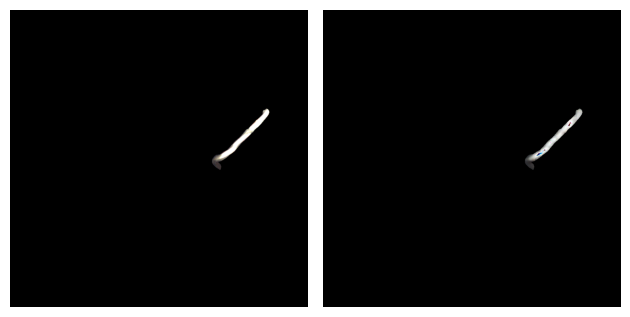

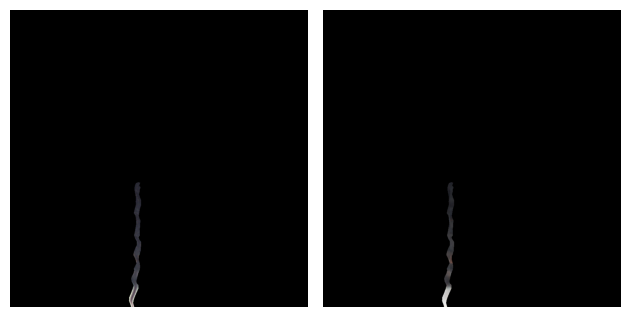

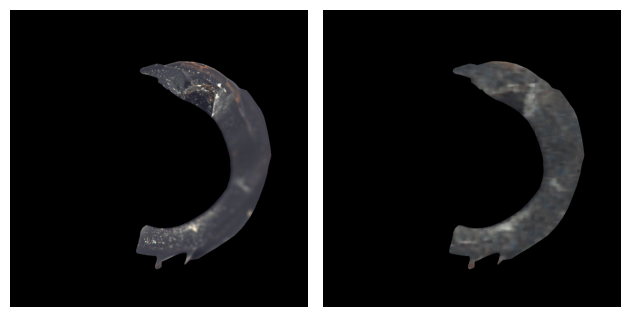

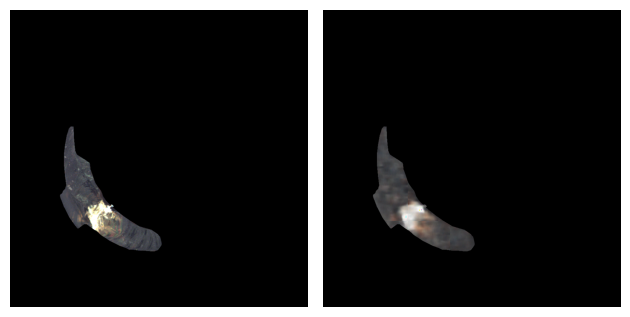

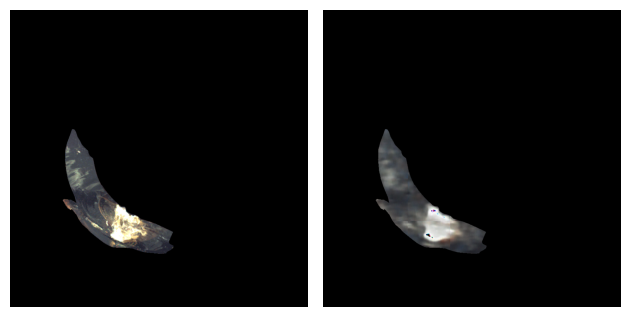

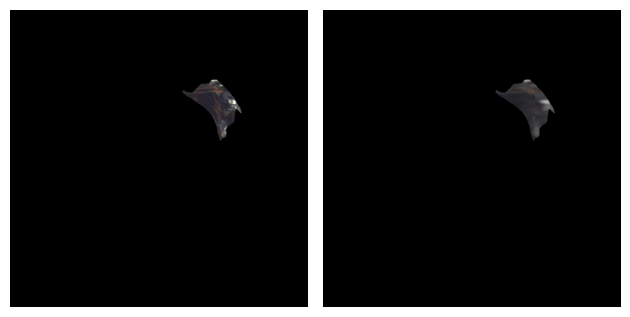

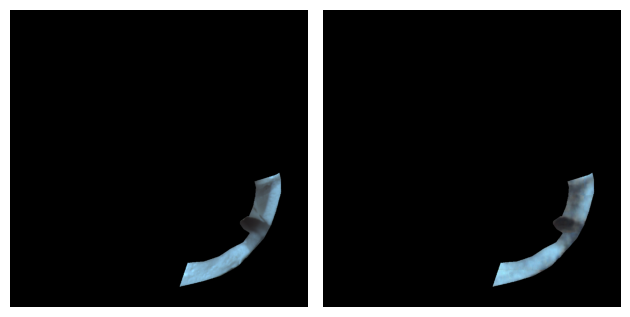

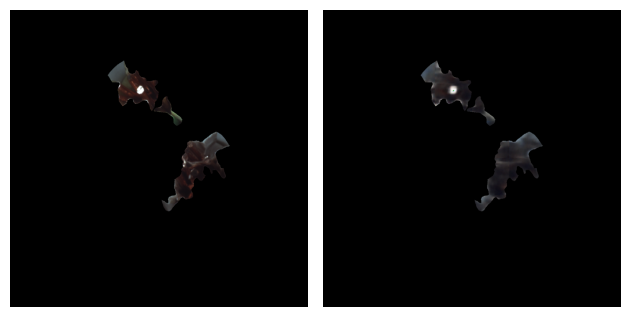

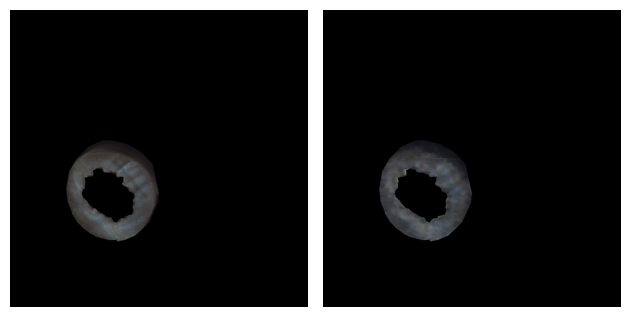

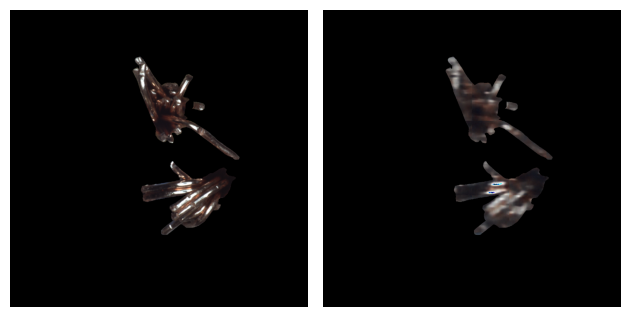

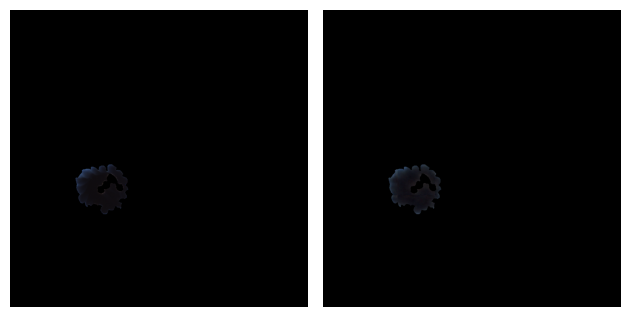

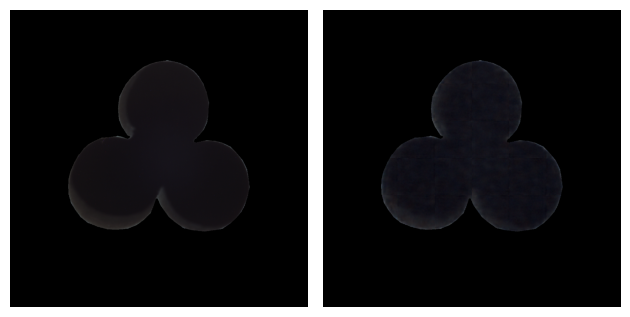

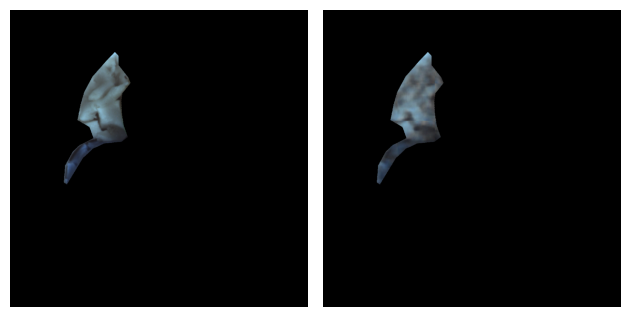

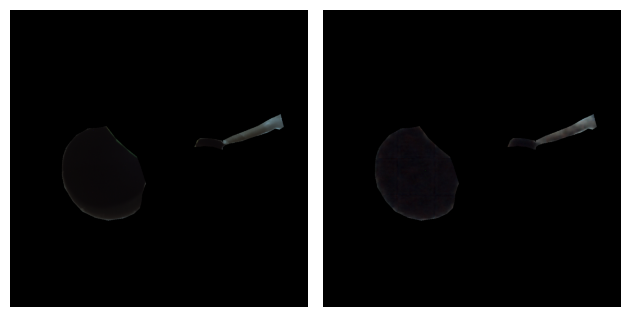

In [9]:
import cv2 as cv
with os.scandir(f'{working_directory}/masked_defects/clean') as objects:
    files = [entry.name for entry in objects]

for i in range(1, len(files)+1):
    image = cv.imread(f'/kaggle/working/masked_defects/clean/{i}.png')
    image1 = cv.imread(f'/kaggle/working/masked_defects/generated/{i}.png')
    image[:,:,[0,2]] = image[:,:,[2,0]]
    image1[:,:,[0,2]] = image1[:,:,[2,0]]

    plt.subplot(1,2,1); plt.imshow(image); plt.axis('off')
    plt.subplot(1,2,2); plt.imshow(image1); plt.axis('off')

    plt.tight_layout()
    plt.show()